In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pdfminer.six


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 74.1 MB/s eta 0:00:00


In [3]:
pip install rapidfuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.2 MB/s eta 0:00:00


In [4]:
!pip install faiss-gpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.6 MB/s eta 0:00:00


In [5]:
from transformers import pipeline



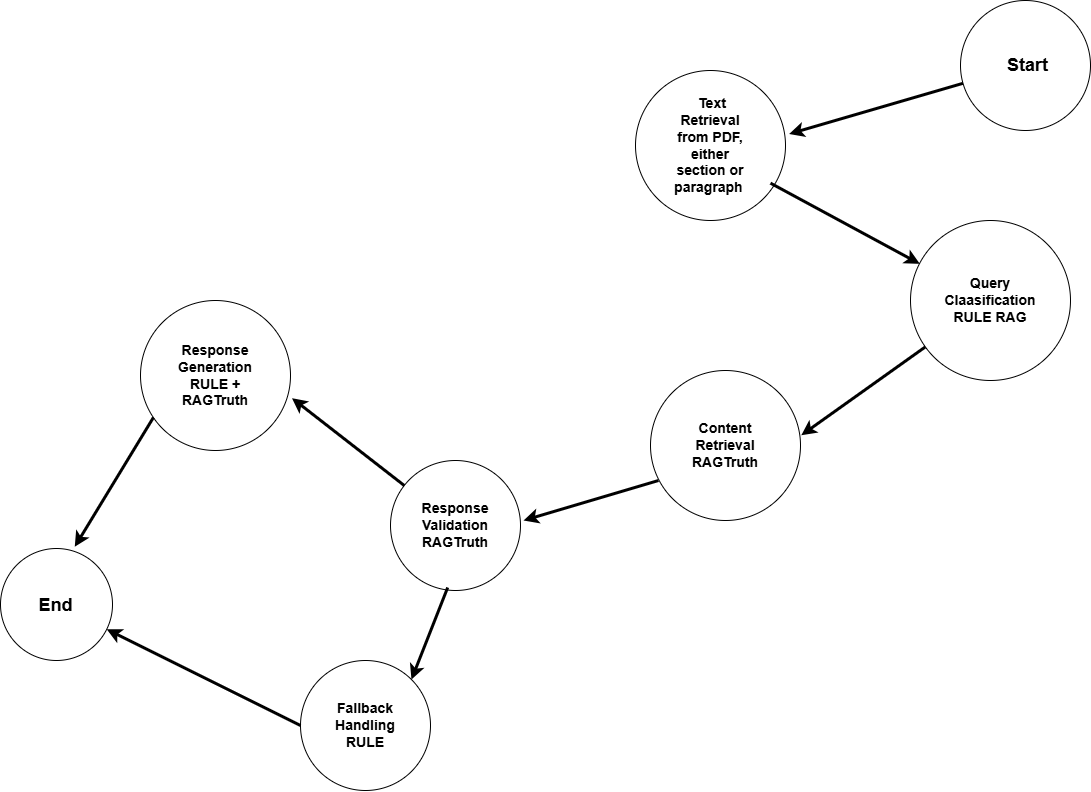











1.   Task 1: Text Retrieval and Storing


*   Extraction of text from the PDF.
*   Segementation of content into chunks, I have tried with two ways: Section and Paragraph.
*   Creating Embeddings.
*   Storing Embeddings in a vector database, here FAISS.




2.   Task 2: Query Classification (RULE RAG)



*   Defining the RULES.
*   Query Parsing.
*   Section Prioritization.

3.   Task 3: Content Retrieval (RAGTruth)


*   Semantically searching indexed knowledge base using query embeddings.
*   Rank retrieved chunks by relevance scores, in my case cosine similarity.

4.   Task 4: Response Validation (RAGTruth)


*   Validating the retrieved content using a confidence threshold.
*   If multiple sources are retrieved, cross-check for consistency.
*   Eliminating low-confidence chunks

5.   Task 5: Response Generation (RULE + RAGTruth)


*   RULE for structured generation, using templates.
*   RAGTruth to generate answers directly from validated content, I have text summarizer.

6.   Task 6: Response Validation (RULE)


*   Defining RULEs for fallback activation, using threshold information.
*   Generation of fallback messages.








# **EVERYTHING INCLUDING IMPORTS PUT INTO SAME CELL FOR COHERENCY**



In [12]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from rapidfuzz import process, fuzz
import spacy
import re

# Loading pre-trained models
nlp_model = SentenceTransformer('multi-qa-MPNet-base-dot-v1')
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
nlp = spacy.load("en_core_web_sm")


# Task 1: Extract Text and Segment by Paragraphs
def extract_text_pdfminer(pdf_path):
    """Extract text from a PDF."""
    from pdfminer.high_level import extract_text
    return extract_text(pdf_path)


def segment_into_paragraphs(content):
    """Split content into paragraphs for finer granularity."""
    paragraphs = content.split("\n\n")  # Split by double newlines
    return [p.strip() for p in paragraphs if p.strip()]  # Remove empty strings


def segment_pdf_into_paragraphs(text):
    """Segment entire PDF into paragraphs."""
    return segment_into_paragraphs(text)


# Task 2: Query Classification
RULES = {
    "Definition": ["what is", "define", "explain"],
    "Procedural": ["how to", "steps", "process", "procedure", "register", "admission"],
    "Policy": ["fee", "refund", "eligibility", "rules", "policy"],
    "Contact": ["contact", "email", "phone", "whom to contact"]
}


def classify_query_using_rules(query):
    """Classify the query intent based on predefined rules."""
    query_lower = query.lower()
    for intent, keywords in RULES.items():
        if any(keyword in query_lower for keyword in keywords):
            return intent
    return "General"  # Default fallback


# Task 3: Semantic Search with FAISS
def generate_embeddings(chunks):
    """Generate embeddings for a list of text chunks."""
    return nlp_model.encode(chunks, convert_to_tensor=False)


def store_in_faiss(embeddings):
    """Store embeddings in a FAISS vector index."""
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    faiss.normalize_L2(embeddings)
    index.add(embeddings)
    return index


def retrieve_relevant_paragraphs(query, faiss_index, paragraphs, model, top_k=5):
    """Retrieve top-k most relevant paragraphs using FAISS."""
    paragraph_embeddings = model.encode(paragraphs, convert_to_tensor=False)
    temp_faiss_index = faiss.IndexFlatL2(paragraph_embeddings.shape[1])
    faiss.normalize_L2(paragraph_embeddings)
    temp_faiss_index.add(np.array(paragraph_embeddings, dtype='float32'))

    query_embedding = model.encode([query], convert_to_tensor=False)
    faiss.normalize_L2(query_embedding)

    distances, indices = temp_faiss_index.search(np.array(query_embedding).astype('float32'), top_k)

    return [{"content": paragraphs[idx], "distance": distances[0][i]} for i, idx in enumerate(indices[0])]


# Task 4: Validation
def validate_retrieved_paragraphs(retrieved_chunks, confidence_threshold=0.5):
    """Validate retrieved content by filtering low-confidence results."""
    validated_chunks = [chunk for chunk in retrieved_chunks if chunk["distance"] < confidence_threshold]
    return validated_chunks if validated_chunks else "Sorry, no relevant content was found."


# Task 5: Generate User-Friendly Response
def generate_response(query, validated_chunks, query_intent, summarizer):
    """Generate a user-friendly response using summarization."""
    if isinstance(validated_chunks, str):  # Handle fallback case
        return validated_chunks

    combined_content = "\n".join([chunk["content"] for chunk in validated_chunks])

    prompt = f"{query_intent.capitalize()} query: {query}. Relevant details:\n{combined_content}"
    try:
        summary = summarizer(prompt, max_length=150, min_length=50, do_sample=False)
        return summary[0]["summary_text"]
    except Exception:
        return combined_content  # Fallback: return the combined content directly


# Task 6: Named Entity Validation
def extract_named_entities(query):
    """Extract named entities (NER) from the query using spaCy."""
    doc = nlp(query)
    return [ent.text for ent in doc.ents]


def is_entity_present_in_data(ner_list, data, threshold=85):
    """Check if named entities are present in the data using fuzzy matching."""
    for ner in ner_list:
        match = process.extractOne(ner, " ".join(data).split(), scorer=fuzz.ratio)
        if not match or match[1] < threshold:
            return False
    return True


def validate_entities_in_response(query, response, paragraphs):
    """Validate that critical named entities from the query are present in the data."""
    ner_list = extract_named_entities(query)
    if not is_entity_present_in_data(ner_list, paragraphs):
        return f"Sorry, I couldn’t find relevant information for your query: '{query}'."
    return response


# Main Pipeline
def main_pipeline(query, pdf_path):
    """Main pipeline for paragraph-based query processing."""
    # Task 1: Extract and segment content into paragraphs
    text = extract_text_pdfminer(pdf_path)
    paragraphs = segment_pdf_into_paragraphs(text)

    # Task 2: Classify query intent
    query_intent = classify_query_using_rules(query)

    # Task 3: Generate embeddings and create FAISS index
    embeddings = generate_embeddings(paragraphs)
    faiss_index = store_in_faiss(np.array(embeddings, dtype='float32'))

    # Task 3: Retrieve relevant paragraphs
    retrieved_paragraphs = retrieve_relevant_paragraphs(query, faiss_index, paragraphs, nlp_model, top_k=5)

    # Task 4: Validate retrieved content
    validated_paragraphs = validate_retrieved_paragraphs(retrieved_paragraphs, confidence_threshold=1)

    # Task 5: Generate response
    response = generate_response(query, validated_paragraphs, query_intent, summarizer)

    # Task 6: Validate named entities in the response
    final_response = validate_entities_in_response(query, response, paragraphs)

    return final_response


# Run Pipeline
if __name__ == "__main__":
    query = "What is the meaning of university?"
    pdf_path = '/content/drive/MyDrive/input.pdf'

    print("Starting pipeline...")
    final_response = main_pipeline(query, pdf_path)
    print("\nFinal Response:")
    print(final_response)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Starting pipeline...


Your max_length is set to 150, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)



Final Response:
Definition query: What is the meaning of university?. Relevant details: At the University                Academics                Admission afer the payment is received by the University.                Semester.                At the University                                               “University’s” role in society.                 “Universities’ role in the society’.


In [6]:
!pip install gradio


In [13]:
import gradio as gr

# Define the function for Gradio
def query_pipeline(query, pdf_file):
    """Process user query and return a response."""
    try:
        # Use the file path directly from the NamedTemporaryFile
        pdf_path = pdf_file.name

        # Run the main pipeline
        response = main_pipeline(query, pdf_path)
        return response
    except Exception as e:
        return f"An error occurred: {str(e)}"


# Set up the Gradio interface
interface = gr.Interface(
    fn=query_pipeline,
    inputs=[
        gr.Textbox(label="Enter Your Query", placeholder="E.g., What is the meaning of university?"),
        gr.File(label="Upload a PDF Document", file_types=[".pdf"]),
    ],
    outputs=gr.Textbox(label="Response"),
    title="Query Processing Pipeline",
    description="Upload a PDF and ask a query to retrieve relevant information.",
)

# Launch the Gradio interface
interface.launch()



Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3625dc156820e4baec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
